<a href="https://colab.research.google.com/github/pastrop/kaggle/blob/master/fraud_dection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection Notebook Using Isolation Forest

In [0]:
# Use seaborn for the correlation heatmap
!pip install seaborn

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import gridspec

import pandas as pd
import seaborn as sns

import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

# Datetime related libraries
import time
import datetime
import dateutil.parser

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# file upload while using Google Colab
from google.colab import files
uploaded = files.upload()

Saving creditcardfraud.zip to creditcardfraud.zip


In [4]:
#Unzipping if needed
!unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          

**Data Exploration**

In [22]:
start = time.time()
df = pd.read_csv('creditcard.csv')
df=df.drop(['Time'], axis=1)
df.describe()
#print("Running time in seconds =", time.time() - start)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35865.000000,35864.000000,35864.000000,35864.000000,35864.000000,35864.000000
mean,-0.208441,0.072071,0.718784,0.195531,-0.217138,0.096022,-0.116966,0.033112,0.257749,-0.085977,0.454607,-0.537405,0.293419,0.267774,0.083327,-0.001043,0.165243,-0.087745,-0.037002,0.044854,-0.030933,-0.113353,-0.041582,0.007556,0.135935,0.021804,0.010620,0.003868,84.234999,0.002872
std,1.835596,1.539390,1.539467,1.408688,1.387536,1.310437,1.256348,1.240914,1.237668,1.136330,1.136421,1.416542,1.159540,1.166093,0.958393,0.933253,1.069565,0.858461,0.816341,0.673701,0.768819,0.640294,0.544625,0.593310,0.435901,0.506545,0.389179,0.301702,227.051922,0.053514
min,-30.552380,-40.978852,-31.103685,-5.172595,-42.147898,-23.496714,-26.548144,-41.484823,-7.175097,-14.166795,-2.985309,-17.769143,-3.808724,-19.214325,-4.152532,-12.227189,-18.587366,-8.061208,-4.932733,-13.694584,-20.262054,-8.593642,-26.751119,-2.836627,-7.495741,-1.438650,-8.567638,-9.617915,0.000000,0.000000
25%,-0.960307,-0.500439,0.244644,-0.714691,-0.819569,-0.644998,-0.598057,-0.155525,-0.524577,-0.565374,-0.363475,-1.526641,-0.493591,-0.246655,-0.478372,-0.490076,-0.331509,-0.563253,-0.527465,-0.161541,-0.239535,-0.536436,-0.178540,-0.326904,-0.127244,-0.331731,-0.063197,-0.007233,6.990000,0.000000
50%,-0.234411,0.113232,0.827482,0.188445,-0.256224,-0.162715,-0.073143,0.043626,0.133530,-0.141490,0.426968,-0.169977,0.216019,0.220231,0.206071,0.063504,0.108132,-0.069379,-0.035345,-0.022248,-0.081470,-0.087315,-0.051998,0.061889,0.175722,-0.063465,0.008837,0.021115,22.000000,0.000000
75%,1.162162,0.754596,1.456477,1.078566,0.302760,0.485900,0.436217,0.307942,0.989833,0.359002,1.235437,0.461918,1.056416,0.910341,0.764064,0.560196,0.601313,0.408374,0.472320,0.166725,0.095121,0.297263,0.076212,0.398932,0.421051,0.301191,0.086582,0.076000,76.062500,0.000000
max,1.960497,16.713389,4.101716,13.143668,34.099309,22.529298,36.677268,20.007208,10.392889,12.701539,12.018913,4.846452,4.465413,7.692209,3.832930,6.098529,9.253526,4.295648,4.555359,17.281859,22.614889,5.805795,13.876221,4.014444,5.525093,3.517346,11.135740,5.678671,7879.420000,1.000000


In [0]:
df.head()

In [9]:
data_shape = df.shape
print(data_shape)

(35865, 31)


In [11]:
unknown_count = df.isna().sum().drop_duplicates()
unknown_count[unknown_count>0]

V26    1
dtype: int64

In [24]:
# Correlation Analysis - NEEDS REFACTORING
# Parameters
THRESHOLD = 0.7 # Correlation Coefficient Threshold of Interest
#printing formats
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Sample to calculate correlations (using filtered set of column, run exlusion calculation first)
#df_model1_sample = measurements_filtered.sample(frac=0.3, random_state=42)
df_sample = df.drop(['Class'],axis=1).sample(frac=0.3, random_state=42)

#List of columns after fitering numeric geo columns out
#df_model1_sample_filtered = df_model1_sample.filter(column_geo_include).columns

start = time.time()

# Correlations, positive and negative. Round to 2 decimals and filling NaN with 0
df_corr = round(df_sample.corr(),3).fillna(0)

print("CORRELATION MATRIX")
np.set_printoptions(suppress=True, precision=3, linewidth=1000)
print(df_corr)

n_columns = df_corr.shape[1]
column_list = list(df_corr.columns)

#Upper triangle matrix of correlation coefficients
corr_matrix = df_corr.values
triu_corr_matrix = np.triu(corr_matrix, k=1)

#printing technical data that is used in follow-up calculations or/and troubleshooting
print("TRIANGILATED CORRELATION MATRIX")
print(triu_corr_matrix)

i=0
corr_ranking=[] # initializing array of correlated pairs
for i in range(n_columns):
  for j in range(i):
    #if abs(triu_corr_matrix[j][i]) > THRESHOLD and abs(triu_corr_matrix[j][i]) <= 1:
    temp=triu_corr_matrix[j][i],column_list[i], column_list[j]
    corr_ranking.append(temp)

#Ranked Correlation Coeff Array - High to Low
corr_ranking.sort(reverse=True)
print("ranked correlation array")
print(corr_ranking)
 
print("Running time in seconds =", time.time() - start)

CORRELATION MATRIX
           V1     V2     V3     V4     V5     V6     V7     V8     V9    V10    V11    V12    V13    V14    V15    V16    V17    V18    V19    V20    V21    V22    V23    V24    V25    V26    V27    V28  Amount
V1      1.000 -0.065  0.293 -0.119  0.026  0.152  0.231 -0.098 -0.048  0.041 -0.041  0.067 -0.001  0.146  0.046  0.121  0.122  0.014  0.002 -0.073 -0.081  0.012  0.003 -0.016  0.193  0.017 -0.194  0.244  -0.208
V2     -0.065  1.000 -0.248  0.094 -0.208  0.046  0.033  0.057 -0.036 -0.029  0.126 -0.150  0.072 -0.109  0.039 -0.068 -0.122 -0.026 -0.014 -0.064  0.055 -0.097  0.040 -0.033 -0.074 -0.046  0.037  0.119  -0.476
V3      0.293 -0.248  1.000 -0.166  0.287  0.015  0.379 -0.300  0.176  0.227 -0.152  0.162 -0.013  0.258 -0.163  0.068  0.227  0.064 -0.055 -0.091 -0.012  0.237  0.041  0.023 -0.198  0.063 -0.198  0.072  -0.142
V4     -0.119  0.094 -0.166  1.000 -0.052 -0.080 -0.149  0.093 -0.040 -0.096  0.070 -0.099  0.023 -0.078 -0.083 -0.165 -0.033 -0.054 -0.0

In [0]:
    # Correlation plot related parameters calculation
    col_corr = [] # Set of all the names of highly correlated columns
    for i in range(len(df_model1_corr.columns)):
        for j in range(len(df_model1_corr.columns)):
            if (abs(df_model1_corr.iloc[j, i]) > 0.5) and (abs(df_model1_corr.iloc[j, i]) < 0.9) and (df_model1_corr.columns[i] not in col_corr) and i != j:
                colname = df_model1_corr.columns[i] # getting the name of column
                col_corr.append(colname)
    print(col_corr)
    top_ten_set = set()
    for item in top_10_corr:
      for i in range(1,len(item)):
        top_ten_set.add(item[i])
    print("top_ten_set: {}".format(top_ten_set))
    if len(top_ten_set)>0:
      df_model1_filtered = df_model1.filter(top_ten_set)
    else:
      df_model1_filtered=df_model1

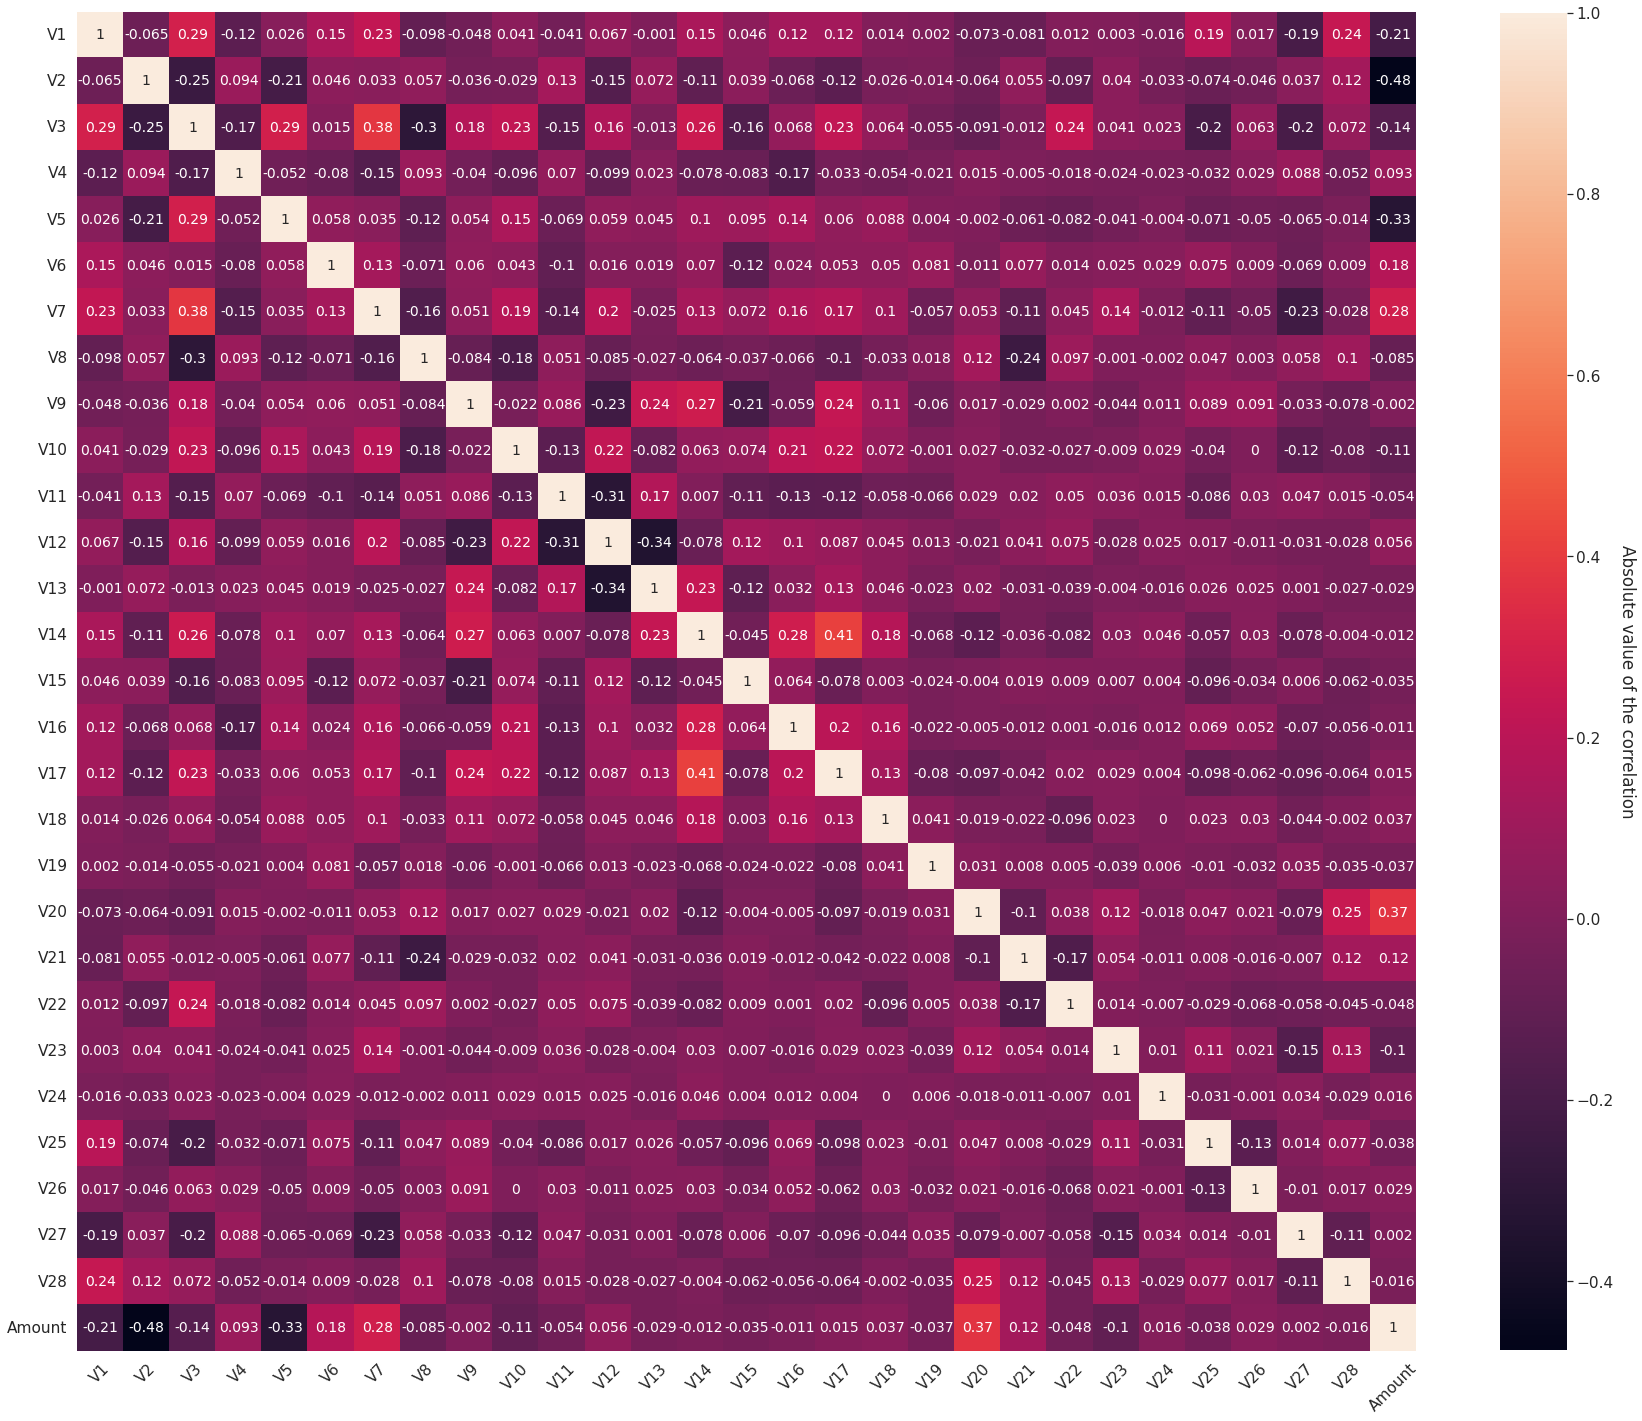

In [25]:
# HeatMap Using Seaborn
sns.set()
# this scales up all text, but does not affect annot (see annot_kws={'size':1.4})
sns.set(font_scale=1.4)
# compute the correlation matrix
#corr = df_model1_filtered.corr()
fig = plt.subplots(figsize=(30,30))
cmap = sns.diverging_palette(0, 359, as_cmap=True)
# annot controls the correlation values display, bizarre shrink-value properly scales the colorbar 
ax = sns.heatmap(df_corr, square=True, cbar_kws={'shrink': 0.82}, annot=True, annot_kws={'size': 14})
# take care of the labels printing
labels_list = df_sample.columns
# this centers and prints horizontally the y labels
ax.set_yticklabels(labels_list, rotation=0, va='center')
# this rotates the x labels
ax.set_xticklabels(labels_list, rotation=45, va='top')
ax.collections[0].colorbar.set_label('Absolute value of the correlation', rotation=-90, va='bottom')
plt.show()

# Isolation Forest based Fraud Detection

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

**Data Scaling**

In [0]:
#Data Normalization - Fare
#Standard Scaler
#X = df['COLUMN'].values.reshape(-1,1) - array reshaping
X = df['Fare'].values.reshape(-1,1)
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)

#MinMaxScaler
scaler_min_max = MinMaxScaler(feature_range=(0, 1))
rescaledX_min_max = scaler_min_max.fit_transform(X)